In [5]:
pip install mlxtend --upgrade --no-deps

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


X_train shape: (27562, 48, 48, 1)
Y_train shape: (27562, 5)
X_test shape: (3446, 48, 48, 1)
Y_test shape: (3446, 5)
X_val shape: (3446, 48, 48, 1)
Y_val shape: (3446, 5)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
430/430 - 51s - loss: 0.4351 - accuracy: 0.4396 - val_loss: 0.4720 - val_accuracy: 0.3891 - lr: 1.0000e-04 - 51s/epoch - 118ms/step
Epoch 2/100
430/430 - 39s - loss: 0.3826 - accuracy: 0.5649 - val_loss: 0.3763 - val_accuracy: 0.5998 - lr: 1.0000e-04 - 39s/epoch - 90ms/step
Epoch 3/100
430/430 - 40s - loss: 0.3506 - accuracy: 0.6212 - val_loss: 0.3226 - val_accuracy: 0.6773 - lr: 1.0000e-04 - 40s/epoch - 92ms/step
Epoch 4/100
430/430 - 39s - loss: 0.3304 - accuracy: 0.6595 - val_loss: 0.3331 - val_accuracy: 0.6747 - lr: 1.0000e-04 - 39s/epoch - 90ms/step
Epoch 5/100
430/430 - 39s - loss: 0.3161 - accuracy: 0.6829 - val_loss: 0.2924 - val_accuracy: 0.7214 - lr: 1.0000e-04 - 39s/epoch - 90ms/step
Epoch 6/100
430/430 - 39s - loss: 0.3053 - accuracy: 0.7038 - val_loss: 0.2943 - val_accuracy: 0.7086 - lr: 1.0000e-04 - 39s/epoch - 90ms/step
Epoch 7/100
430/430 - 39s - loss: 0.2972 - accuracy: 0.7169 - val_loss: 0.2825 - val_accuracy: 0.7382 - lr: 1.0000e-04 - 39s/epoch - 90ms/ste

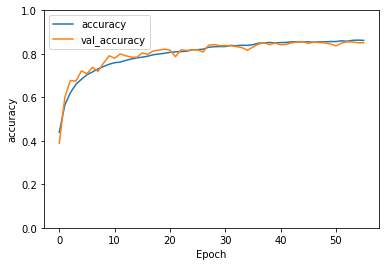

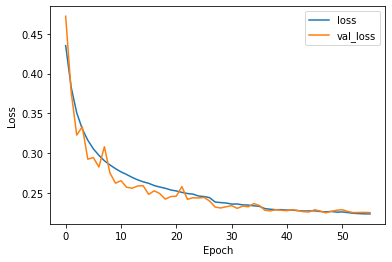

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn import model_selection
from math import ceil


# Loads csv files and appends pixels to X and labels to y
def preprocessData():
    data = pd.read_csv('drive/MyDrive/ML/fer13csv/fer2013/fer2013.csv')
    labels = pd.read_csv('drive/MyDrive/ML/fer13csv/fer2013/fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y


def cleanAndNormalizeData(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown and NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    #Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Using mask to remove disgust and fear images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('disgust')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Normalize image vectors
    X = X / 255.0

    return X, y


def splitData(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test


def dataAugmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen


def showAugmentedImages(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
    plt.show()


def defineModel(input_shape=(48, 48, 1), classes=5):
    num_features = 64

    model = Sequential()

    #Stage 1
    model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.5))

    #Stage 2
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #Stage 3
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    #Stage 4
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    #Stage 5
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Flatten())

    # Fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))

    return model


def graphs(history):
    #Accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    #Loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()


def saveModelWeights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('Saved-Models\\model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Save weights to JSON
    model.save_weights('Saved-Models\\model' + str(test_acc) + '.h5')


def trainModel():
    fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger']

    X, y = preprocessData()
    X, y = cleanAndNormalizeData(X, y)
    x_train, y_train, x_val, y_val, x_test, y_test = splitData(X, y)
    datagen = dataAugmentation(x_train)

    epochs = 100
    batch_size = 64

    print("X_train shape: " + str(x_train.shape))
    print("Y_train shape: " + str(y_train.shape))
    print("X_test shape: " + str(x_test.shape))
    print("Y_test shape: " + str(y_test.shape))
    print("X_val shape: " + str(x_val.shape))
    print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch
    earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
    )

    lrScheduler = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1,
    )

    callbacks = [
        earlyStopping,
        lrScheduler,
    ]
    model = defineModel(input_shape=x_train[0].shape, classes=len(fer_classes))
    model.summary()
    model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    trainingHistory = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val), verbose=2,
                        callbacks=callbacks)
    test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

    graphs(trainingHistory)
    saveModelWeights(model, test_acc)


trainModel()

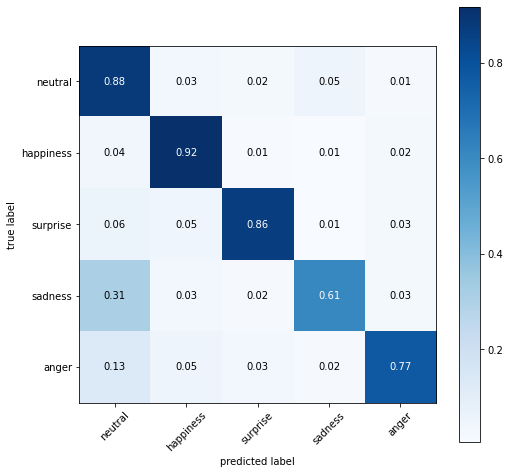

In [13]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix


X, y = preprocessData()
X, y = cleanAndNormalizeData(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = splitData(X, y)

# Load model from JSON file
json_file = open('/content/Saved-Models\model8441.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

# Load weights and them to model
model.load_weights('/content/Saved-Models\model8441.h5')

pred_test_labels = model.predict(x_test)

conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))

emotions = {0: 'neutral', 1: 'happiness', 2: 'surprise', 3: 'sadness', 4: 'anger'}

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

